# Exploratory Data Analysis - Diabetes Health Indicator

This notebook seeks to conduct an exploratory data analysis (EDA) of the cleaned data set from the Centers for Disease Control and Prevention (CDC) 2015 BRFSS Survey Data isloated for diabetes indicators. Diabetes is a cronic disease affecting a significant population of the world that puts significant economic burden on those who suffer from it. Early diagnosis of this ailment can lead to significant lifestyle changes and effective treatment, thus, a predictive diabetes risk model will be useful for health practicioners as well as at-risk individuals to take appropriate steps to reduce risk. 

The data set in question is collected by the CDC's Behavioral Risk Factor Surveillance System (BRFSS) from 2015, which is a telephone survey of health related indicators collected annually. The cleaned data includes 253,680 examples (individuals) and 21 features. The target indicator has three classes: 0 for individuals with no diabetes, 1 for prediabetes, 2 for diabetes.

In [19]:
# Required imports
import pandas as pd
import numpy as np
import IPython
import altair as alt
from IPython.display import HTML, display
import matplotlib.pyplot as plt
from sklearn.compose import (
    ColumnTransformer,
    make_column_transformer,
)
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import (
    Ridge,
    RidgeCV,
)
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler
)
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## Load Data Set 
- This section will present a sample of the data set and present relevant information.
- The cleaned data does not include `NaN` values and is predominantly binary.

In [20]:
# Sample clean data set with relevant features
df = pd.read_csv('../data/clean/LLCP2015_cleaned.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [21]:
# Check for NULL values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

## Target Rates and Feature Preliminary Information
- 84.2% in the data set do not have diabetes. 1.8% have pre-diabetes. 13.9% has diabetes. 

In [22]:
# determine the target class percentages
total_num = len(df)
no_dia_num = len(df.query('Diabetes_012 == 0'))
dia_num = len(df.query('Diabetes_012 == 2'))
pre_dia_num = len(df.query('Diabetes_012 == 1'))

diabetes_rate = pd.DataFrame([{
    'No Diabetes': round(no_dia_num/total_num, 3),
    'Pre-diabetes': round(pre_dia_num/total_num, 3),
    'Diabetes': round(dia_num/total_num, 3),
}])
print(diabetes_rate)
df.describe().round(3)


   No Diabetes  Pre-diabetes  Diabetes
0        0.842         0.018     0.139


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000,253680.000,253680.000,253680.000,253680.000,253680.000,253680.000,253680.000,253680.000,253680.000,...,253680.000,253680.000,253680.000,253680.000,253680.000,253680.000,253680.000,253680.000,253680.000,253680.000
mean,0.297,0.429,0.424,0.963,28.382,0.443,0.041,0.094,0.757,0.634,...,0.951,0.084,2.511,3.185,4.242,0.168,0.440,8.032,5.050,6.054
std,0.698,0.495,0.494,0.190,6.609,0.497,0.197,0.292,0.429,0.482,...,0.216,0.278,1.068,7.413,8.718,0.374,0.496,3.054,0.986,2.071
min,0.000,0.000,0.000,0.000,12.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000
25%,0.000,0.000,0.000,1.000,24.000,0.000,0.000,0.000,1.000,0.000,...,1.000,0.000,2.000,0.000,0.000,0.000,0.000,6.000,4.000,5.000
50%,0.000,0.000,0.000,1.000,27.000,0.000,0.000,0.000,1.000,1.000,...,1.000,0.000,2.000,0.000,0.000,0.000,0.000,8.000,5.000,7.000
75%,0.000,1.000,1.000,1.000,31.000,1.000,0.000,0.000,1.000,1.000,...,1.000,0.000,3.000,2.000,3.000,0.000,1.000,10.000,6.000,8.000
max,2.000,1.000,1.000,1.000,98.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,5.000,30.000,30.000,1.000,1.000,13.000,6.000,8.000


## Distribution of Features
Let's look at the distributions of the features and target to get a better understanding of the data set.

From the distribution of all features, it is immediately apparent that there is a significant class imbalance skewed towards individuals with no diabetes. Condsidering we are interested in predicting diabetes and not overly concerned with false positives, we will be interested in building a model that prioritizes `recall` score.

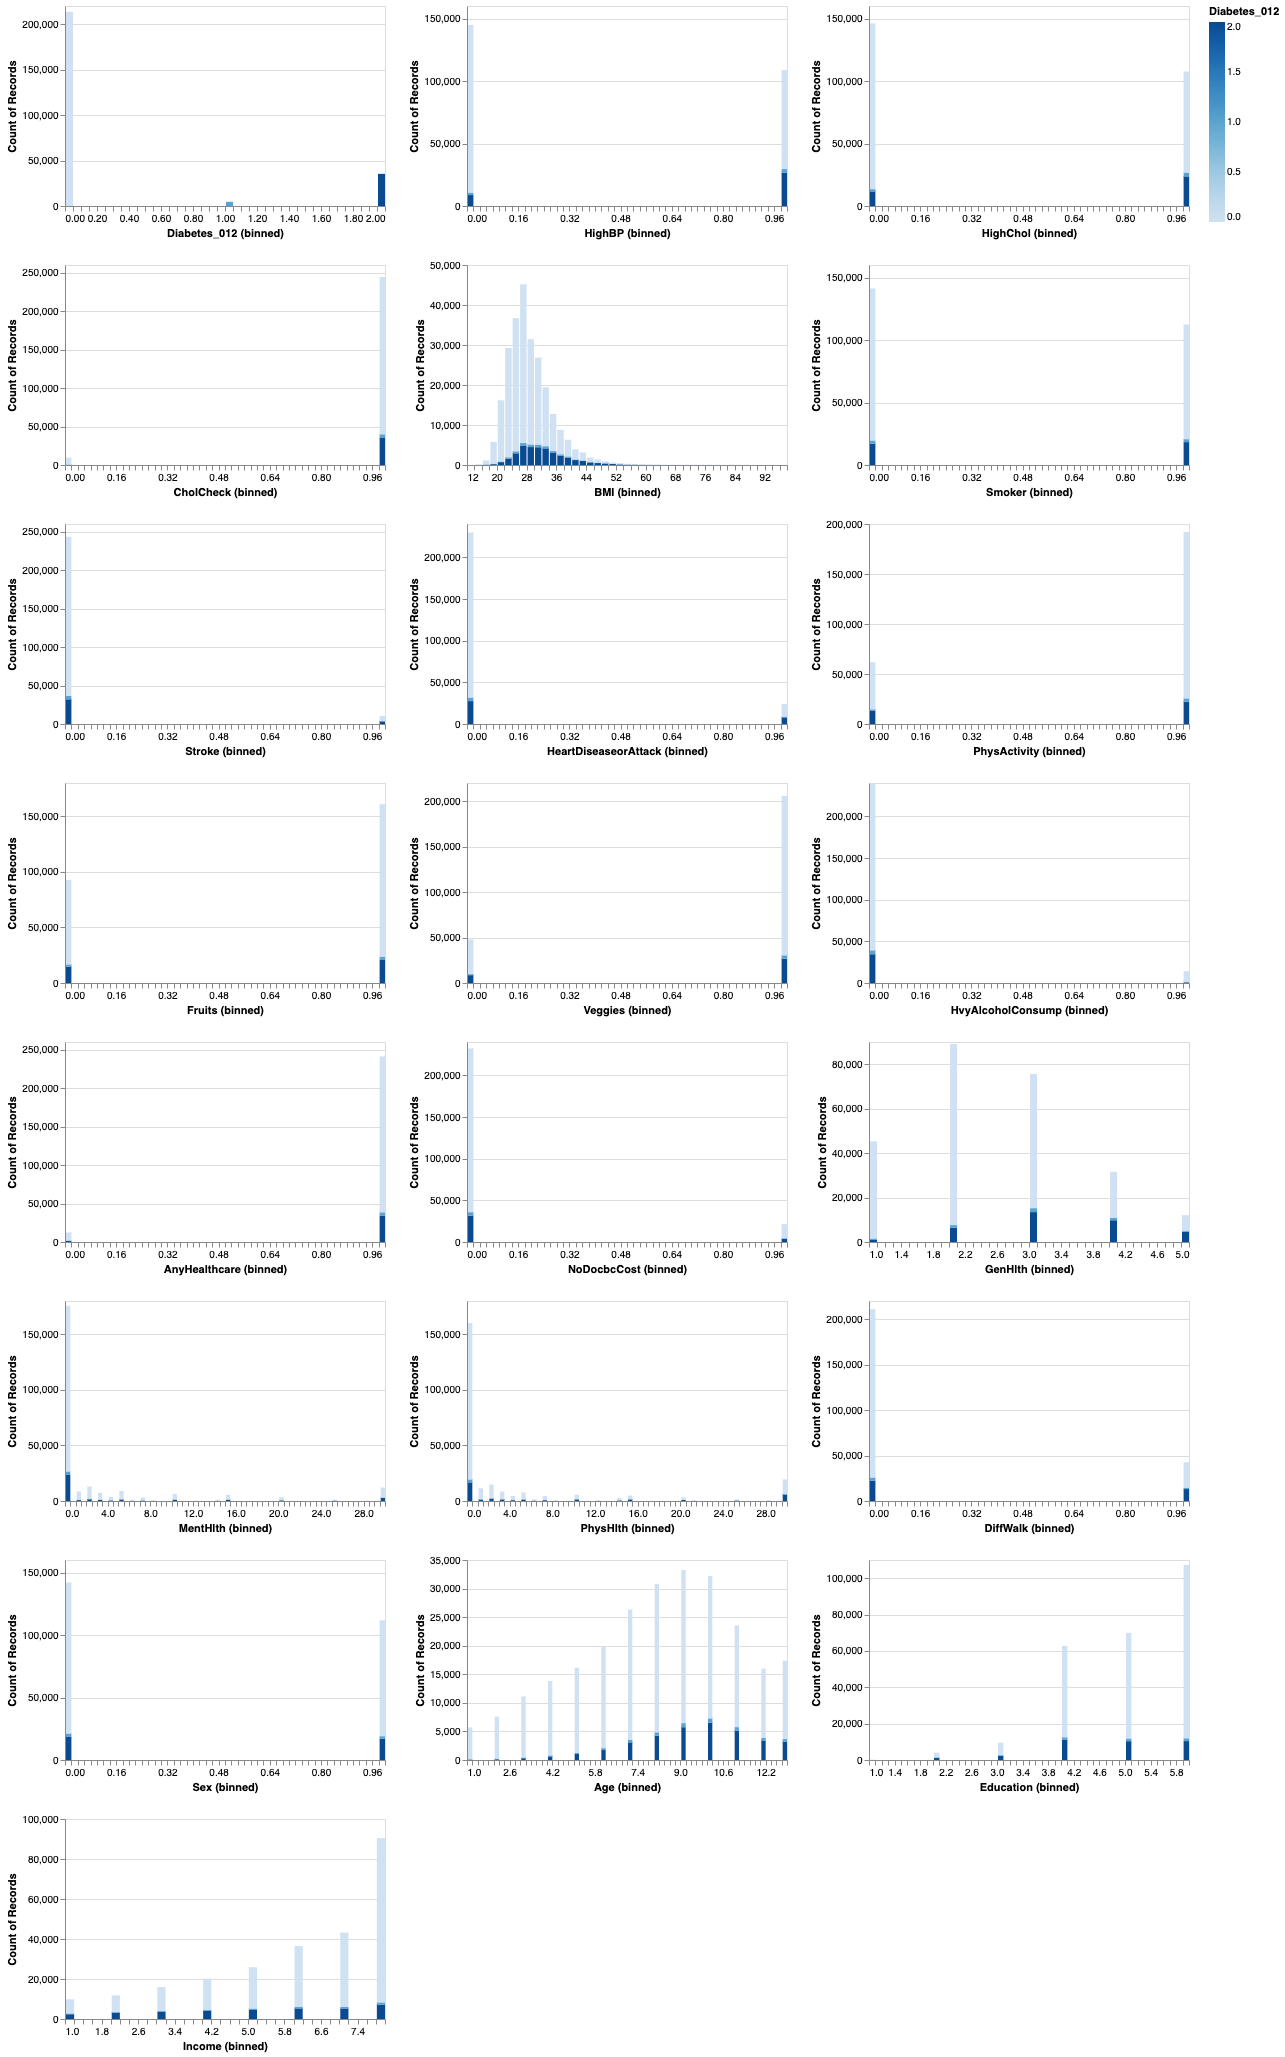

In [23]:
# Distributions of complete data set
df_cols = df.columns.tolist()

df_plot = alt.Chart(df).mark_bar().encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=60)),
    alt.Y('count()'),
    color = 'Diabetes_012'
).properties(
    height=200,
    width=320
).repeat(
    df_cols,
    columns = 3)

df_plot

## Check Correlations
Check which features are highly correlated with Spearman's correlation plot.

In [24]:
# Correlation matrix
corr_plot = df.corr('spearman').style.background_gradient() 
corr_plot

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
Diabetes_012,1.000000,0.271668,0.210668,0.068018,0.235887,0.063040,0.105887,0.178564,-0.121988,-0.042268,-0.059353,-0.057244,0.014530,0.037379,0.297138,0.044921,0.161718,0.223567,0.030143,0.186357,-0.126862,-0.172611
HighBP,0.271668,1.000000,0.298199,0.098508,0.243756,0.096991,0.129575,0.209361,-0.125267,-0.040555,-0.061266,-0.003972,0.038425,0.017358,0.303300,0.020499,0.149550,0.223618,0.052207,0.344535,-0.141970,-0.179161
HighChol,0.210668,0.298199,1.000000,0.085642,0.136298,0.091299,0.092620,0.180765,-0.078046,-0.040859,-0.039874,-0.011543,0.042230,0.013310,0.208640,0.044060,0.119331,0.144672,0.031205,0.266355,-0.068850,-0.087905
CholCheck,0.068018,0.098508,0.085642,1.000000,0.040285,-0.009929,0.024158,0.044206,0.004190,0.023849,0.006121,-0.023730,0.117626,-0.058255,0.046351,-0.013270,0.030475,0.040585,-0.022115,0.093533,0.003870,0.015263
BMI,0.235887,0.243756,0.136298,0.040285,1.000000,0.023089,0.022428,0.063659,-0.144611,-0.096067,-0.068040,-0.052448,-0.013761,0.052151,0.257342,0.053936,0.116096,0.179543,0.089349,-0.024591,-0.123277,-0.092192
Smoker,0.063040,0.096991,0.091299,-0.009929,0.023089,1.000000,0.061173,0.114441,-0.087401,-0.077666,-0.030678,0.101619,-0.023251,0.048946,0.159009,0.060940,0.093197,0.122463,0.093662,0.119304,-0.173566,-0.132663
Stroke,0.105887,0.129575,0.092620,0.024158,0.022428,0.061173,1.000000,0.203002,-0.069151,-0.013389,-0.041124,-0.016950,0.008776,0.034804,0.163685,0.049819,0.127681,0.176567,0.002978,0.129060,-0.072970,-0.123728
HeartDiseaseorAttack,0.178564,0.209361,0.180765,0.044206,0.063659,0.114441,0.203002,1.000000,-0.087299,-0.019790,-0.039167,-0.028991,0.018734,0.031000,0.242243,0.034763,0.156630,0.212709,0.086096,0.227639,-0.095910,-0.141485
PhysActivity,-0.121988,-0.125267,-0.078046,0.004190,-0.144611,-0.087401,-0.069151,-0.087299,1.000000,0.142756,0.153150,0.012392,0.035505,-0.061638,-0.256241,-0.082526,-0.179494,-0.253174,0.032482,-0.088049,0.200248,0.202022
Fruits,-0.042268,-0.040555,-0.040859,0.023849,-0.096067,-0.077666,-0.013389,-0.019790,0.142756,1.000000,0.254342,-0.035288,0.031544,-0.044243,-0.105474,-0.064153,-0.045278,-0.048352,-0.091175,0.066934,0.114929,0.076415
